#  Inert doublet model

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import os, sys, inspect
import commands
from hep import *

Define functions to change from general basis to physical basis 

In [3]:
def run_official_idm(MHX,MH3,MHC,laL,la2,Mh,check=False):
    pd.Series({'MHX':MHX,'MH3':MH3,'MHC':MHC,'laL':laL,'la2':la2,'Mh':Mh}).to_csv('mo.dat',sep=' ')
    omegah2=-1
    if os.path.isfile('../micromegas/IDM/main'):
        mo=commands.getoutput("../micromegas/IDM/main mo.dat")
        
    return mo

def phys_to_int(mH,mA,mHc,lambda_L,v):
    mH2=mH*mH;mA2=mA*mA;mHc2=mHc*mHc;v2=v*v
    lambda_5=(mH2-mA2)/v2
    mu2=mH2-lambda_L*v2
    lambda_3=2.*(mHc2-mu2)/v2
    lambda_4=-lambda_3-lambda_5+2*lambda_L
    return mu2,lambda_3,lambda_4,lambda_5

def int_to_phys(mu2,lambda_3,lambda_4,lambda_5,v):
    v2=v*v
    tachyons=False
    mHc2=mu2+lambda_3*v2/2.
    if mHc2<0: tachyons=True
    mH2=mu2+(lambda_3+lambda_4+lambda_5)*v2/2.
    if mH2<0: tachyons=True
    mA2=mu2+(lambda_3+lambda_4-lambda_5)*v2/2.
    if mA2<0: tachyons=True
    if tachyons: print "Warning: Tachyionic masses"
    return np.sqrt(np.abs(np.array([mH2,mA2,mHc2]))),(lambda_3+lambda_4+lambda_5)/2 

Define function to run official micromegas IDM

In [4]:
def run_official_idm_lha(spc,check=False):
    laL=(spc.blocks['MINPAR'][3]+spc.blocks['MINPAR'][4]+spc.blocks['MINPAR'][5])/2.
    MHX=spc.blocks['MASS'][35];MH3=spc.blocks['MASS'][36];MHC=spc.blocks['MASS'][37]
    la2=spc.blocks['MINPAR'][2];Mh=spc.blocks['MASS'][25]
    return run_official_idm(MHX,MH3,MHC,laL,la2,Mh,check=check)



## Check one point

###  With SARAH implementation
Based in Scotogenic model by Avelino

In [5]:
a=hep(MODEL='SimplifiedDMIDM')

In [6]:
v=a.vev
#lambda_1=0.13
ipt=pd.Series({'MHX':40,'MH3':701,'MHC':701,'lambda_L':0.1}) #Official IDM micromegas names
mu2,lambda_3,lambda_4,lambda_5=phys_to_int(ipt.MHX,ipt.MH3,ipt.MHC,ipt.lambda_L,v)
print 'expected:',ipt.MHX,ipt.MH3,ipt.MHC
print 'obtained:',int_to_phys(mu2,lambda_3,lambda_4,lambda_5,v)
devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda3Input' %lambda_3
a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda4Input' %lambda_4
a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lambda_5
a.LHA.blocks['MINPAR'][6]='%0.8E       #mEt2Input' %mu2
moc=a.runmicromegas(Direct_Detection=True)
print 'Omega h^2 =',a.Series.Omega_h2

expected: 40.0 701.0 701.0
obtained: (array([  40.,  701.,  701.]), 0.099999999999999645)
Omega h^2 = 0.14


See full `LesHouches.in.SimplifiedDMIDM` and `SPheno.spc.SimplifiedDMIDM` in __Appendix 1__

###  Wiht the official IDM in micrOMEGAS at 
`./micromegas/IDM`

In [7]:
omhof=run_official_idm_lha(a.LHA_out,check=True)
omo=a.micromegas_output(omhof)
print 'Omega h^2 =',a.Series.Omega_h2

Omega h^2 = 0.14


See full micromegas input in __Appendix 2__

## Scan $m_{H^0}$

In [8]:
df=pd.DataFrame()
ipt=pd.Series({'MHX':40,'MH3':701,'MHC':701,'lambda_L':0.1})
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
dm_masses=np.linspace(40,700,100)
for MHX in dm_masses:
    if np.where(dm_masses==MHX)[0][0]%10==0: #find the index of the array entry
        print np.where(dm_masses==MHX)[0][0]
    ipt.MHX=MHX
    mu2,lambda_3,lambda_4,lambda_5=phys_to_int(ipt.MHX,ipt.MH3,ipt.MHC,ipt.lambda_L,a.vev)
    a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lambda_5
    a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda4Input' %lambda_3
    a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda3Input' %lambda_4
    a.LHA.blocks['MINPAR'][6]='%0.8E       #mEt2Input' %mu2
    a.runmicromegas(Direct_Detection=True)
    a.Series=a.Series.append(ipt)
    a.Series=a.Series.append(pd.Series({'MH0':a.LHA_out.blocks['MASS'][35],\
                                        'MA0':a.LHA_out.blocks['MASS'][36],\
                                        'MHc':a.LHA_out.blocks['MASS'][37]}))
    omhof=run_official_idm_lha(a.LHA_out,check=True)
    omo=a.micromegas_output(omhof)
    a.Series['Omega_h2_official']=omo.Omega_h2
    a.Series['proton_SI_official']=omo.proton.SI
    a.Series['neutron_SI_official']=omo.neutron.SI
    df=df.append(a.Series,ignore_index=True)

0
10
20
30
40
50
60
70
80
90


### Relic density

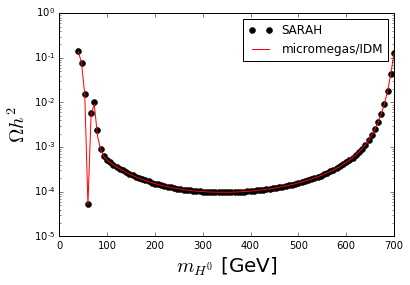

In [32]:
dfm=df[df.MH0<df.MHc]
plt.semilogy(dfm.MH0,dfm.Omega_h2,'ko',label='SARAH')
plt.semilogy(dfm.MH0,dfm.Omega_h2_official,'r-',label='micromegas/IDM')
plt.xlabel(r'$m_{H^0}$ [GeV]',size=20)
plt.ylabel(r'$\Omega h^2$',size=20)
plt.legend(loc='best')
plt.savefig('omega.pdf')

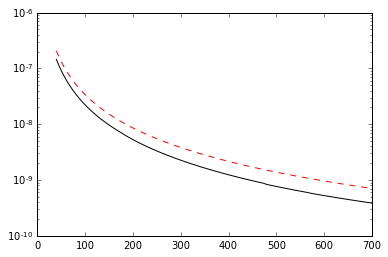

In [9]:
dfm=df[df.MH0<df.MHc]
plt.semilogy(dfm.MH0,dfm.proton_SI,'k-')
plt.semilogy(dfm.MH0,dfm.proton_SI_official,'r--')

In [10]:
dfd=pd.DataFrame()
ipt=pd.Series({'MHX':40,'MH3':120,'MHC':120,'lambda_L':0.1})
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
dm_masses=np.linspace(90,700,100)
for MHX in dm_masses:
    if np.where(dm_masses==MHX)[0][0]%10==0: #find the index of the array entry
        print np.where(dm_masses==MHX)[0][0]
    ipt.MHX=MHX
    ipt.MH3=MHX
    ipt.MHC=MHX
    mu2,lambda_3,lambda_4,lambda_5=phys_to_int(ipt.MHX,ipt.MH3,ipt.MHC,ipt.lambda_L,a.vev)
    a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lambda_5
    a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda4Input' %lambda_3
    a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda3Input' %lambda_4
    a.LHA.blocks['MINPAR'][6]='%0.8E       #mEt2Input' %mu2
    a.runmicromegas(Direct_Detection=True)
    a.Series=a.Series.append(ipt)
    a.Series=a.Series.append(pd.Series({'MH0':a.LHA_out.blocks['MASS'][35],\
                                        'MA0':a.LHA_out.blocks['MASS'][36],\
                                        'MHc':a.LHA_out.blocks['MASS'][37]}))
    omhof=run_official_idm_lha(a.LHA_out,check=True)
    omo=a.micromegas_output(omhof)
    a.Series['Omega_h2_official']=omo.Omega_h2
    a.Series['proton_SI_official']=omo.proton.SI
    a.Series['neutron_SI_official']=omo.neutron.SI
    dfd=dfd.append(a.Series,ignore_index=True)

0
10
20
30
40
50
60
70
80
90


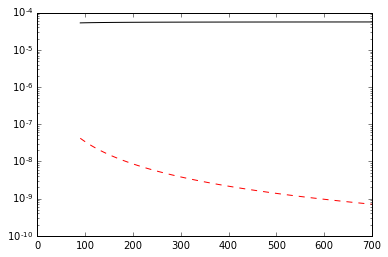

In [11]:
plt.semilogy(dfd.MH0,dfd.proton_SI,'k-')
plt.semilogy(dfd.MH0,dfd.proton_SI_official,'r--')

In [19]:
v=a.vev
mc=600
ipt=np.array([mc,mc,mc,0.1])
mu2,lambda_3,lambda_4,lambda_5=phys_to_int(ipt[0],ipt[1],ipt[2],ipt[3],v)
print 'expected:',ipt
print 'obtained:',int_to_phys(mu2,lambda_3,lambda_4,lambda_5,v)
devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda3Input' %lambda_3
a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda4Input' %lambda_4
a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lambda_5
a.LHA.blocks['MINPAR'][6]='%0.8E       #mEt2Input' %mu2
moc=a.runmicromegas(Direct_Detection=True)
print 'Omega h^2 =',a.Series.Omega_h2,a.Series.proton_SI
#spc.blocks['MASS'].entries
#TODO: Change PDF of scalar sector in both scotogenic and IDM

expected: [  6.00000000e+02   6.00000000e+02   6.00000000e+02   1.00000000e-01]
obtained: (array([ 600.,  600.,  600.]), 0.10000000000000001)
Omega h^2 = 0.109 5.599e-05


In [18]:
omhof=run_official_idm_lha(a.LHA_out,check=True)
omo=a.micromegas_output(omhof)
print 'Omega h^2 =',omo.Omega_h2,omo.proton_SI

Omega h^2 = 0.00325 5.331e-05


In [17]:
a.Series

GFFermiconstant        1.166370e-05
Zbosonpolemass         9.118870e+01
alphasMZSMMSbar        1.187000e-01
lambda1                5.340000e-01
lambda2                0.000000e+00
lambda3               -5.273559e-16
lambda4                2.000000e-01
lambda5                0.000000e+00
mEt2                   4.839375e+05
mbmbSMMSbar            4.180000e+00
mtaupole               1.776690e+00
mtoppole               1.735000e+02
Omega_h2               1.450000e-01
proton_SI              5.628000e-05
neutron_SI             2.458000e-03
MH3                    7.000000e+02
MHC                    7.000000e+02
MHX                    7.000000e+02
lambda_L               1.000000e-01
MA0                    7.000000e+02
MH0                    7.000000e+02
MHc                    7.000000e+02
Omega_h2_official      1.452100e-01
proton_SI_official     4.181000e-11
neutron_SI_official    4.264000e-11
dtype: float64

In [26]:
a.LHA_out.blocks['MASS'].entries

OrderedDict([(25, 254.454395),
             (35, 40.0),
             (36, 120.0),
             (37, 120.0),
             (23, 91.1887),
             (24, 80.3497269),
             (1, 0.005),
             (3, 0.095),
             (5, 4.18),
             (2, 0.0025),
             (4, 1.27),
             (6, 173.5),
             (11, 0.00051099893),
             (13, 0.105658372),
             (15, 1.77669)])

##  Appendix 1
Full input/output for check point with
* $m_h=126 $GeV
* $m_[H^0]= 40\ \text{GeV}$
* $m_[A^0]= 701\ \text{GeV}  $
* $m_[H^+]= 701\ \text{GeV}  $
* $\lambda_L=0.1$

In [49]:
cat LesHouches.in.SimplifiedDMIDM

BLOCK MODSEL
   1   1              #  1/0: High/low scale input 
   2   1              # Boundary Condition  
   6   1              # Generation Mixing 

BLOCK SMINPUTS
   2   1.166370E-05   # G_F,Fermi constant 
   3   1.187000E-01   # alpha_s(MZ) SM MSbar 
   4   9.118870E+01   # Z-boson pole mass 
   5   4.180000E+00   # m_b(mb) SM MSbar 
   6   1.735000E+02   # m_top(pole) 
   7   1.776690E+00   # m_tau(pole) 

BLOCK MINPAR
   1   1.30000000E-01       #lambda1Input
   2   0.0000000E+00  # lambda2Input
   3   1.63584985E+01       #lambda3Input
   4   -8.07924924E+00       #lambda4Input
   5   -8.07924924E+00       #lambda5Input
   6   -4.46245686E+03       #mEt2Input

BLOCK SPHENOINPUT
   1   -1             # error level 
   2   0              # SPA conventions 
   11   1              # calculate branching ratios 
   13   1               # 3-Body decays: none (0), fermion (1), scalar (2), both (3)
   14   0              # Run couplings to scale of decaying particle 
   12   1.000E-1

In [50]:
cat SPheno.spc.SimplifiedDMIDM

# SUSY Les Houches Accord 2 - SimplifiedDM/IDM Spectrum + Decays + Flavor Observables
# SPheno module generated by SARAH
# ----------------------------------------------------------------------
# SPheno v3.3.8  
#   W. Porod, Comput. Phys. Commun. 153 (2003) 275-315, hep-ph/0301101
#   W. Porod, F.Staub, Comput.Phys.Commun.183 (2012) 2458-2469, arXiv:1104.1573
# SARAH: 4.8.5   
#   F. Staub; arXiv:0806.0538 (online manual)
#   F. Staub; Comput. Phys. Commun. 181 (2010) 1077-1086; arXiv:0909.2863
#   F. Staub; Comput. Phys. Commun. 182 (2011)  808-833; arXiv:1002.0840
#   F. Staub; Comput. Phys. Commun. 184 (2013)  1792-1809; arXiv:1207.0906
#   F. Staub; Comput. Phys. Commun. 185 (2014)  1773-1790; arXiv:1309.7223 
# Including the calculation of flavor observables based on the FlavorKit 
#   W. Porod, F. Staub, A. Vicente; Eur.Phys.J. C74 (2014) 8, 2992; arXiv:1405.1434 
# Two-loop masss corrections to Higgs fields based on 
#   M. D. Goodsell, K. Nickel, F. Staub; arXiv:1411.0675 
#  

## Appendix 2
Input file for official IDM in micromegas

In [51]:
cat mo.dat

MH3 701.0
MHC 701.0
MHX 40.0000076
Mh 125.548349
la2 0.0
laL 0.10000001


In [31]:
%%writefile draft.tex
\documentclass[12pt,letterpaper]{article}
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%Force pdflatex processing even with "$ latex" (required by arXiv)
\pdfoutput=1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\usepackage[utf8]{inputenc}
\usepackage{amsmath}
\usepackage{slashed}
\usepackage{amssymb}
\usepackage{amsthm}
\usepackage{xcolor}
\usepackage[colorinlistoftodos]{todonotes}
\definecolor{nicered}{rgb}{0.7,0.1,0.1}
\definecolor{nicegreen}{rgb}{0.1,0.5,0.1}
\usepackage[colorlinks=true,citecolor= nicegreen,linkcolor=nicered]{hyperref}
\usepackage{graphicx}
\graphicspath{{figures/}}
\usepackage{siunitx} 
\sisetup{group-minimum-digits=4} %compatibility with PDG

\usepackage{cancel}

\usepackage{comment}
\includecomment{details}
\specialcomment{details}
{\begingroup}{\endgroup}


%%%%%%%%%%%%%%%%%%
\setlength{\textwidth}{180mm}
\setlength{\textheight}{230mm}
\setlength{\oddsidemargin}{-1cm}
\setlength{\evensidemargin}{-1cm}
\setlength{\topmargin}{-1cm}

\title{Comparision of IDM between SARAH and micromegas}

\author{D. Restrepo\footnote{\href{mailto:restrepo@udea.edu.co}{restrepo@udea.edu.co}}
}
\date{}
\begin{document}

\maketitle
\begin{abstract}
  We compare one implementation of the IDM in SARAH based in the Scotogenic Model by Avelino with the official
    implementation of the IDM in micrOMEGAS. While the relic density is the same in the two implementations, SARAH 
    fails to calculate Direct Detection in the case of a degenerate spectrum.  Significative differences are found also
    when the other $Z_2$ odd scalars are decoupled.
\end{abstract}
\section{Introduction}
In Fig.~\ref{fig:om}, the relic density is compared between the the IDM in SARAH based in the Scotogenic Model by Avelino with the official
    implementation of the IDM in micrOMEGAS. We fix the parameters in the physical basis as 
\begin{itemize}
\item  $m_h=126 $GeV
\item  $m_[H^0]= 40\ \text{GeV}$
\item  $m_[A^0]= 701\ \text{GeV}  $
\item  $m_[H^+]= 701\ \text{GeV}  $
\item  $\lambda_L=0.1$
\end{itemize}

\begin{figure}
\includegraphics[scale=0.6]{omega}
  \end{figure}


%\bibliographystyle{h-physrev4}%apsrev4-1long
%\bibliography{susy}



\end{document}


%%% Local Variables: 
%%% mode: latex
%%% TeX-master: "draft"
%%% ispell-local-dictionary: "american"
%%% End:

Overwriting draft.tex


In [29]:
%%bash
pdflatex draft.tex > /dev/null

[Jupyter home](./draft.pdf)